In [1]:
import numpy as np
import astropy.io.fits as pyfits
import astropy.wcs as wcs
from astropy.utils.data import get_pkg_data_filename
from reproject import reproject_interp

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

## Notes

- Present possible approaches: clean r = 5, 10 and 15 pc, need to plot radii on the maps
- Assume that Column density maps cover full extent of the cloud, this seems reasonable (they were well mapped with Herschel)
- Handle unrealistic column densities at the edges of the map
- Cloud sizes in DC+2021: ~ 2.5 pc, Peretto+2023: cloud sizes of HM star formation ~10 pc (Takes this as the reference value)
 => Calculate lifetime for 5, 10, 15 pc radii


- RCW120 and W40 might miss a significant fraction of the mass in the case of the first attempt
- RCW 120: verify with the PPMAP
- RCW 36: need mirror on other side (ASSUME MISS HALF OF THE MASS EJECTION)

- Include all mass in the map (without background). It doesn't only need to escape the molecular gas
- Atomic gas could add significantly to the total mass


Cluster locations:
- M16: 274.67, -13.78  (Sana, Stoop)
- M17: 275.1,  -16.16  (Stoop)
- RCW120: 17:12:20.8  -38:29:25.5 (Martins)
- RCW 79: 13:40:09.1  -61:43:51.9 (Martins)
- RCW 36: 08:59:29   -43:45:06  (Ellerbroek)
- W40: 183127.83−020523.7 (Comeron)
- NGC 7538: 23:13:34.5 +61:30:14.3 (Puga+2010)
- RCW 49: 10:24:11.6  -57:46:42.5 (Tiwari)
- Orion: 05 35 16.46  -05 23 22.8 (From Pabst+2019 extended Fig. 6 caption)

In [2]:
#### user input ####

## parsec in cm
pc_in_cm = 3.09e18 

## solar mass in kg
m_sun = 2e30 

## molecular mass in kg
mol_mass = 2.33 * 1.67e-27

## The gravitational constant
G = 4.3e-3 ## pc / M * (km/s)**2

## radii to plot in pc
radii = [5., 10., 15.]

## the column density treshold to define a molecular cloud
mol_cloud_tresh = 2.0e21

## regions to be analysed with info
## 0: distance
## 1: lower std cluster age
## 2: cluster age
## 3: upper std cluster age
## 4: outflow rate 
## 5: right ascencion of the cluster (either float or string)
## 6: declination  of the cluster (either float or string)
## 7: name of the cluster
names = {
    'W40_CII_final_20_8_0p5_clean': [502.,0.9,0.9,0.9, 0.4e-3, '18:31:27.83', '-02:05:23.7', 'W40'],
    'RCW36_CII_final_20_8_0p5_clean': [950.,0.6,1.1,0.6, 0.3e-3, '08:59:29.0', '-43:45:06.0', 'RCW36'],
    'RCW120_CII_final_20_8_0p5_clean': [1680.,1.2,1.2,1.8, 2.0e-3, '17:12:20.8', '-38:29:25.5', 'RCW120'],
    'OrionA_CII_final_20_8_0p5_clean': [414.,0.5,2.5,0.5, 0.7e-3, '05:35:16.46', '-05:23:22.8', 'M42'],
    'NGC7538_CII_final_20_8_0p5_clean': [2650.,0.85,2.2,0.85, 2.2e-3, '23:13:34.5', '61:30:14.3', 'NGC7538'],
    'RCW79_CII_final_20_8_0p5_clean': [3900.,0.5,2.3,0.5, 4.8e-3, '13:40:09.1', '-61:43:51.9', 'RCW79'],
    'm16_CII_final_20_8_0p5_clean': [1706.,0.2,1.3,0.2, 1.3e-3, 274.67, -13.78, 'M16'],
    'm17_CII_final_20_8_0p5_clean': [1900.,0.15,0.58,0.15, 4.5e-3, 275.1, -16.16, 'M17'],
    'RCW49_CII_final_20_8_0p5_clean': [4160.,0.75,1.25,0.75, 3.0e-3, '10:24:11.6', '-57:46:42.5', 'RCW49'] 
}

In [3]:
## function that converts right ascencion and declination coordinates from hh/dd:mm:ss string format to decimal angle format
def WCStoDecimal(val1, val2):
    ## split the hh:mm:ss coordinates
    val1Res = val1.split(':')
    val2Res = val2.split(':')
    
    ## convert to the decimal format
    ra = float(val1Res[0]) * 15. + float(val1Res[1]) * 15. / 60. + float(val1Res[2]) * 15. / 3600.
    dec = float(val2Res[0]) + float(val2Res[1]) / 60. + float(val2Res[2]) / 3600.
    if(float(val2Res[0]) < 0.):
        dec = float(val2Res[0]) - float(val2Res[1]) / 60. - float(val2Res[2]) / 3600.
        
    return ra, dec

In [4]:
## plot the PDF and get background value
def plot_hist_getNbg(data_rav, reg_name):
    counts, bins, patches = plt.hist(data_rav, bins = int(np.sqrt(data_rav.shape[0]) + 0.5), align = 'left')
    
    ind_max = np.argmax(counts)
    N_bg = bins[ind_max] 
    ## Set a few by hand, based on a visual inspection, that are not automatically found with this simple method
    if(reg_name == 'M17'):
        N_bg = 7.0e21
    #if(reg_name == 'RCW120'):
    #    N_bg = 9.0e22
    if(reg_name == 'W40'):
        N_bg = 4.5e21 # 2.9e21
    
    plt.axvline(x = N_bg, color = 'k', linestyle = '--')
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel('N$_{H_{2}}$ (cm$^{-2}$)')
    plt.ylabel('pixel count')
    
    plt.title(reg_name)

    #plt.savefig('../plotsRCW79/coldens_PDF.pdf', dpi = 300)
    plt.show()
    
    return N_bg

In [5]:
## calculate the escape velocity of a cloud
def v_escape(M, R):
    return np.sqrt(2.*G*M/R)

## calculate the mass and escape velocities from the column density map in given radii
def vals_in_radii(data, pix_coords, pix_size, rads, reg_name):
    ## get the maximum radius and convert to pixel radius
    max_rad = np.nanmax(rads)
    max_rad = int(max_rad / pix_size + 0.5)
    
    ## Define the x and y limits to best studied
    x_cent, y_cent = pix_coords[0], pix_coords[1]
    x_min, y_min = int(x_cent + 0.5) - max_rad - 2, int(y_cent + 0.5) - max_rad - 2
    x_max, y_max = int(x_cent + 0.5) + max_rad + 2, int(y_cent + 0.5) + max_rad + 2
    if(x_min < 0): x_min = 0
    if(y_min < 0): y_min = 0
    if(x_max > len(data[0])): x_max = len(data[0])
    if(y_max > len(data)): y_max = len(data)
    
    ## calculate the background
    data_temp = data[y_min:y_max, x_min:x_max]
    N_bg = plot_hist_getNbg(data_temp.ravel(), reg_name)
    
    ## remove the background
    data = data - N_bg
    data[data < 0.] = 0.
    
    ## sum the total number of molecules within each radii
    counts = [0 for i in range(0, len(rads))]
    mol_sums = [0. for i in range(0, len(rads))]
    mol_H2_sums = [0. for i in range(0, len(rads))]
    
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            ## calculate the distance
            d = np.sqrt((x - x_cent)**2 + (y - y_cent)**2) * pix_size
            
            for a, rad in enumerate(rads):
                if(d < rad and ~np.isnan(data[y][x])):
                    counts[a] += 1
                    mol_sums[a] += data[y][x]
                    
                    ## Count the number of molecules of the molecular cloud (defined as higher column density than 2.0e21)
                    if(data[y][x] > mol_cloud_tresh):
                        mol_H2_sums[a] += data[y][x]
    
    ## calculate the properties of interest
    masses = [s * mol_mass * pix_size**2 * pc_in_cm**2 / m_sun for s in mol_sums] ## total masses
    av_coldens = [s/c for s, c in zip(mol_sums, counts)] ## the average column density
    vescs = [v_escape(m, r) for m, r in zip(masses, rads)] ## the escape velocities
    molcl_masses = [s * mol_mass * pix_size**2 * pc_in_cm**2 / m_sun for s in mol_H2_sums] ## the masses of the molecular cloud
    
    return masses, vescs, av_coldens, molcl_masses
    
    

In [6]:
## plotting functions
def plot_coldens_map(data, w, ra, dec, pix_size, rads, pix_coords = None):
    ## plot the map with the circles and cluster location
    plt.clf()
    
    fig, ax = plt.subplots()
    ax1 = fig.add_subplot(111, projection = w)
    #im = ax1.imshow(data, origin='lower', cmap = 'viridis')
    im = ax1.imshow(np.log10(data), origin='lower', cmap = 'viridis')
    
    ## plot the central cluster
    ax1.scatter(ra, dec, color = 'r', marker = '+', transform=ax1.get_transform('icrs'), s = 20)
    if(pix_coords is not None):
        ax1.scatter(pix_coords[0], pix_coords[1], color = 'k', marker = '^', s = 40)
    
    ## plot the different radii
    for rad in rads:
        pix_rad = rad / pix_size
        circ = Circle(tuple(pix[0]), radius = pix_rad, fill = False, edgecolor = 'r')
        ax1.add_patch(circ)
    
    plt.xlabel('RA [J2000]')
    plt.ylabel('DEC [J2000]')#,labelpad=-1.)
    
    cbar = fig.colorbar(im)
    #cbar.set_label('N$_{H_{2}}$ (cm$^{-2}$)', labelpad = 15.,rotation = 270.)
    cbar.set_label('log[N$_{H_{2}}$ (cm$^{-2}$)]', labelpad = 15.,rotation = 270.)
    
    ax.axis('off')
    
    plt.show()
    

<Figure size 640x480 with 0 Axes>

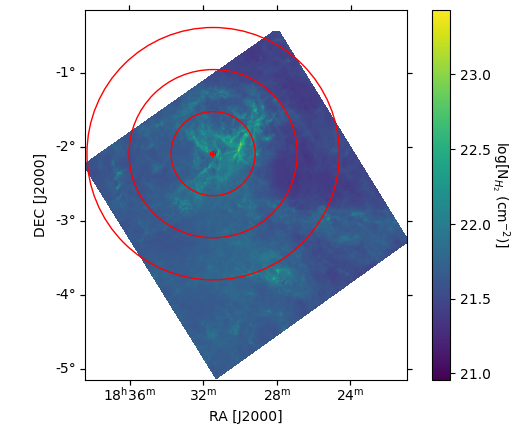

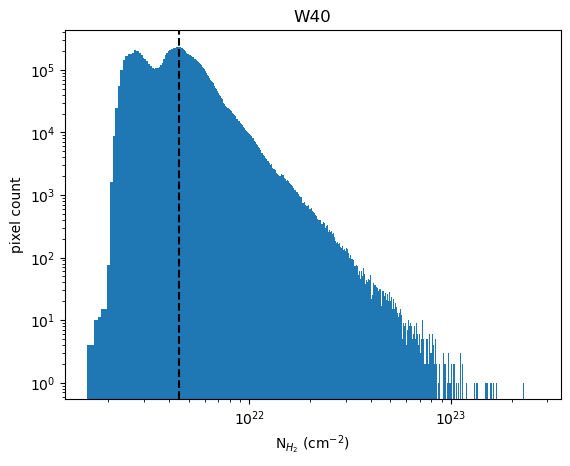

[6165.398470438286, 9966.573674087309, 11898.827168862295]
[3.256452881457653, 2.9276702955959855, 2.6118947611802907]
[4.225819701140838e+21, 1.8112538101193554e+21, 1.1272769093877712e+21]
The molecular cloud masses
[5687.187800090204, 7923.388417347061, 8629.109728291647]


<Figure size 640x480 with 0 Axes>

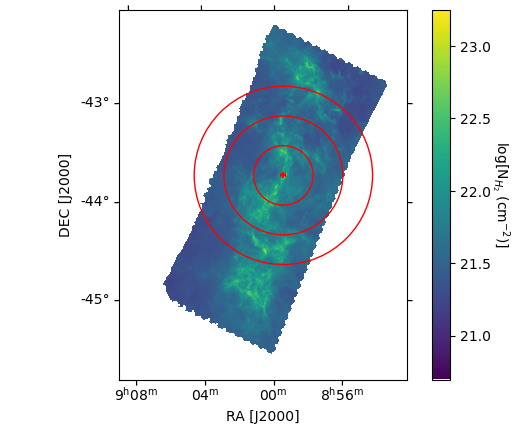

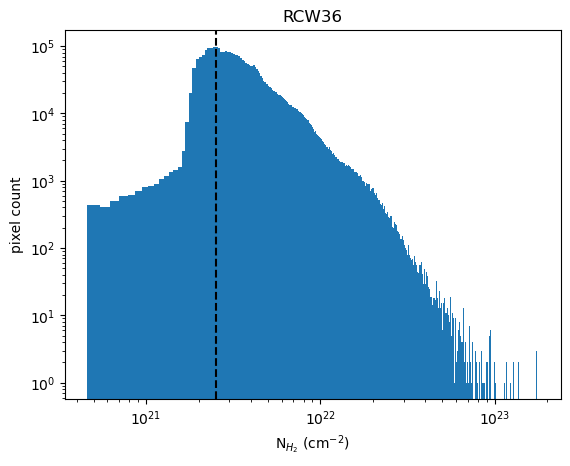

[7717.5861680032185, 19036.77512143365, 29707.914736148767]
[3.6433841698296843, 4.046186674442115, 4.127049525031003]
[5.289764493721767e+21, 3.2707061704909316e+21, 2.782551682945682e+21]
The molecular cloud masses
[7188.231008412925, 16246.28029035307, 24955.14665302097]


<Figure size 640x480 with 0 Axes>

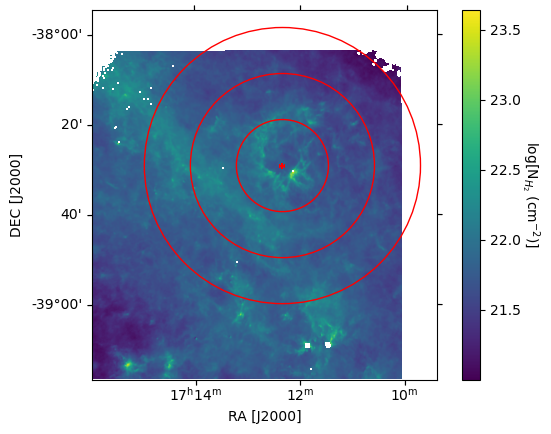

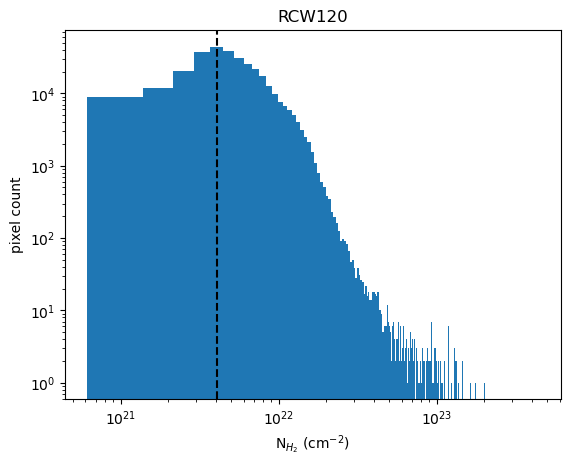

[8404.972436600321, 21471.96981839334, 35709.8698578796]
[3.8021773486980526, 4.297196067649028, 4.524782726111569]
[5.759737027556075e+21, 3.6789270067713907e+21, 2.930129448064427e+21]
The molecular cloud masses
[8023.816752196226, 19923.56054236364, 32228.378871928573]


<Figure size 640x480 with 0 Axes>

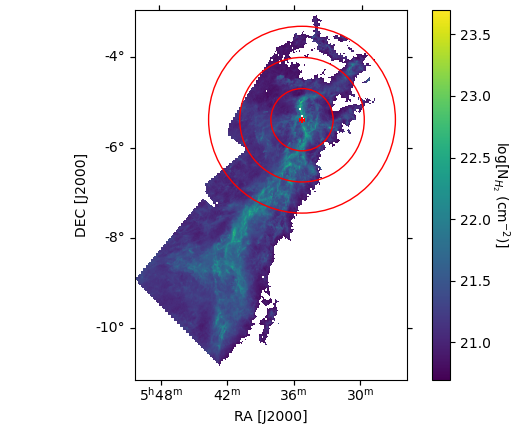

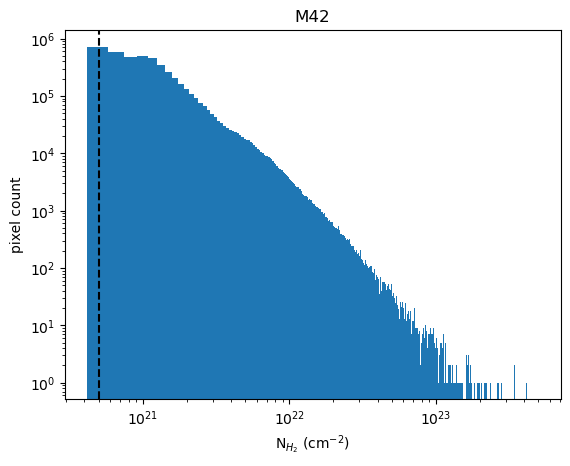

[5239.664989753626, 10190.667439434063, 14104.344205540374]
[3.0020366057688634, 2.960400986000595, 2.843675557767297]
[3.5934363387011426e+21, 1.9640767609157418e+21, 1.680944443376912e+21]
The molecular cloud masses
[4380.116252057203, 7159.8915272748245, 9684.88956106307]


<Figure size 640x480 with 0 Axes>

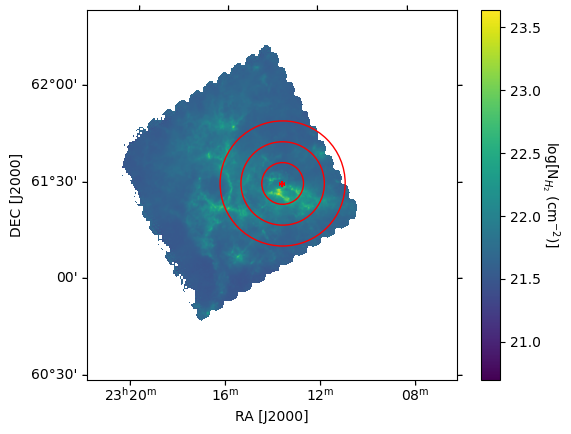

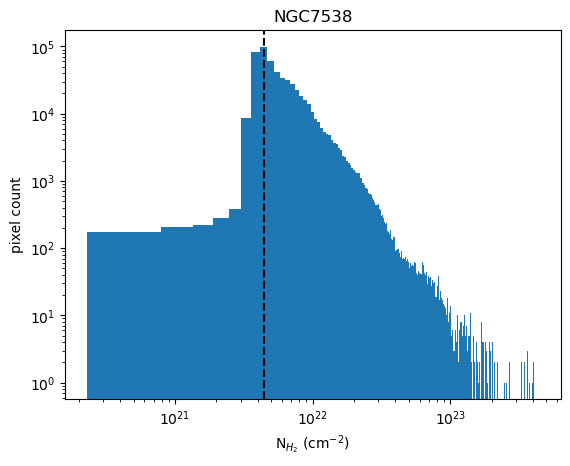

[18557.19856276706, 35013.294698968566, 51617.56565249375]
[5.649635521691584, 5.487388581202626, 5.440043287888105]
[1.272064249142572e+22, 5.9997430710964e+21, 4.026167077590735e+21]
The molecular cloud masses
[18302.78706203821, 33329.57276457174, 47739.86749656841]


<Figure size 640x480 with 0 Axes>

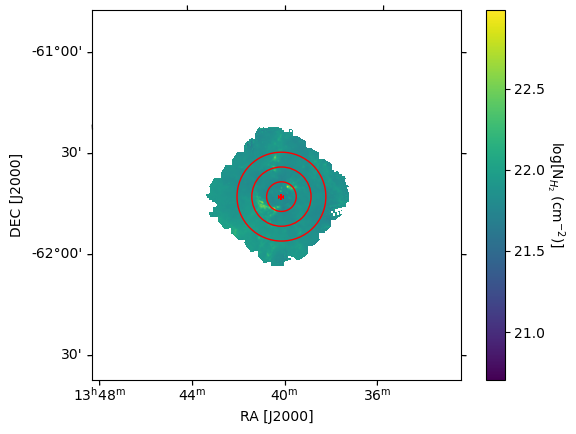

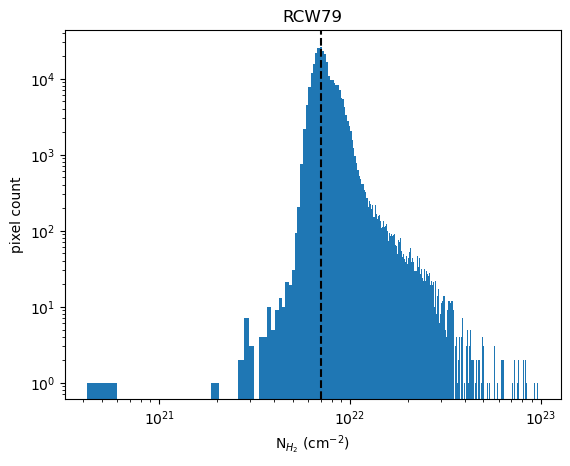

[1726.5831723147849, 7728.450162181836, 13627.585099496355]
[1.7232884425949797, 2.578074308369792, 2.7952010286163516]
[1.1831776647509343e+21, 1.324021014692126e+21, 1.037786539215445e+21]
The molecular cloud masses
[1578.5103003742347, 6300.150494649008, 8507.028059278855]


<Figure size 640x480 with 0 Axes>

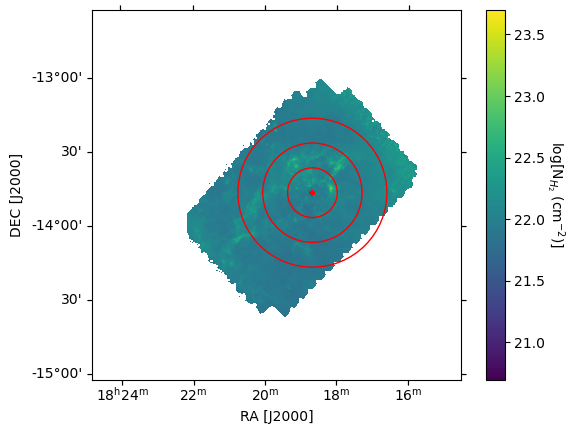

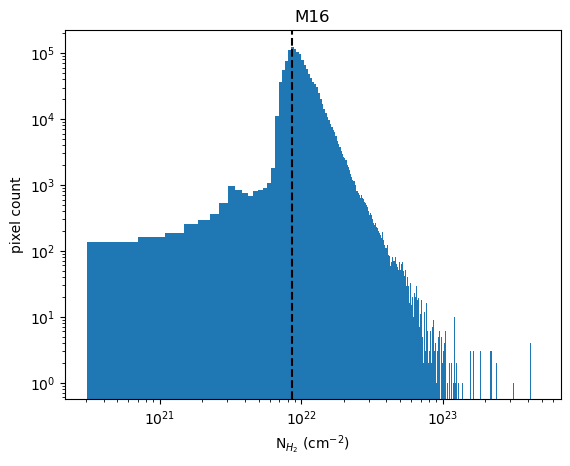

[6012.51998847568, 18995.65308469702, 30724.00446185488]
[3.2158256140808024, 4.041814153673996, 4.197034178019457]
[4.1209269990608077e+21, 3.2548751031650736e+21, 2.374643624963049e+21]
The molecular cloud masses
[5563.012077719315, 16764.573540540674, 25753.022333588862]


<Figure size 640x480 with 0 Axes>

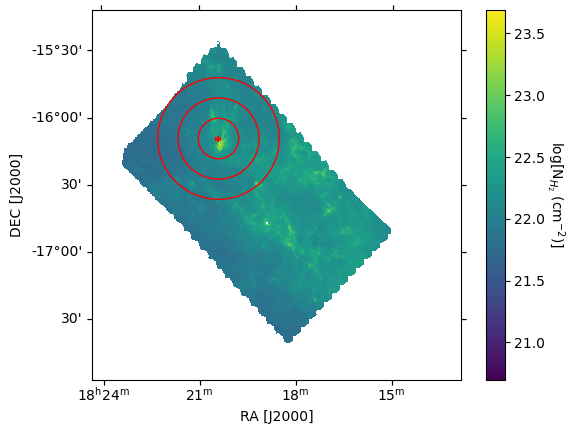

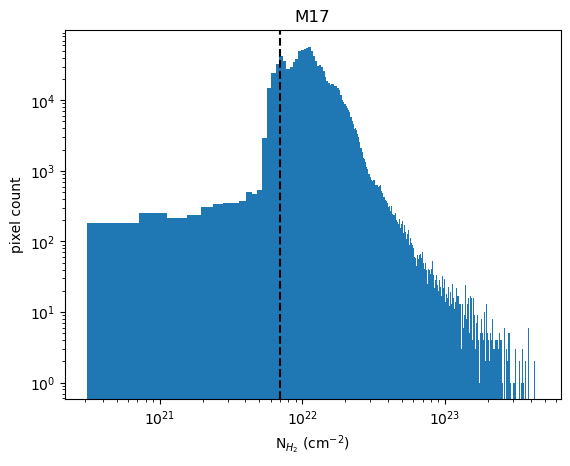

[28522.395388704375, 55092.524557672165, 89226.99458801145]
[7.004178757611168, 6.8832820020392935, 7.152398914382495]
[1.954930601308692e+22, 9.440223015985321e+21, 6.795202270775403e+21]
The molecular cloud masses
[28522.395388704375, 54604.39190743304, 87495.71929841087]


<Figure size 640x480 with 0 Axes>

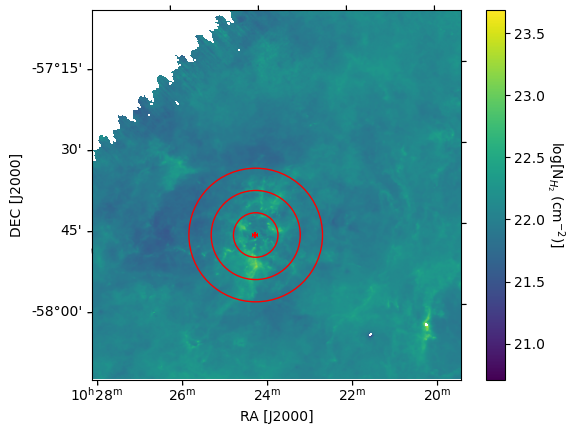

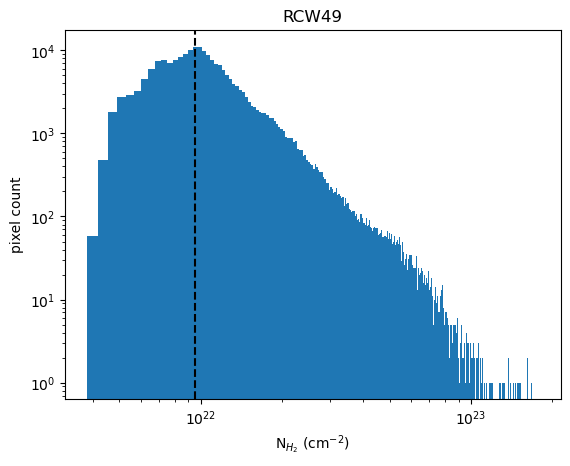

[15340.607076240753, 49031.429738976636, 63763.1109012203]
[5.13671530952749, 6.493614523169658, 6.046281246907031]
[1.0514709292365371e+22, 8.400961320441715e+21, 4.856205613447605e+21]
The molecular cloud masses
[15120.14114980661, 47921.36773470843, 61133.62436051102]


In [7]:
## plot the radii on the column density maps
for name in names.keys():
    ## get the name of the region
    reg_name = names[name][-1]
    
    ## open the fits file
    hdu = pyfits.open('../data_timescale/colDens/' + reg_name + '_coldens_high.fits')
    #if reg_name == 'RCW120':
    #    hdu = pyfits.open('../data_timescale/colDens/' + reg_name + '_coldens_high_reproj_PPMAP.fits')
    data = hdu[0].data
    header = hdu[0].header
    
    ## get the pixel size in pc
    pix_size = names[name][0] * header['CDELT2'] * np.pi/ 180.
    
    ## create world coordinate system from the header
    w = wcs.WCS(header)
    
    ra, dec = names[name][-3], names[name][-2]
    if(isinstance(ra, str)):
        ra, dec = WCStoDecimal(ra, dec)
        
    ## get the x & y coordinates of the cluster
    pix = w.wcs_world2pix(np.array([[ra, dec]]), 1)
        
    ## handle outliers
    data[data < 0.5e21] = np.nan
    data[data > 5e23] = np.nan
    
    ## plot the column density map
    plot_coldens_map(data, w, ra, dec, pix_size, radii)#, pix_coords = pix[0])
    
    masses, vescs, av_coldens, molcl_masses = vals_in_radii(data, pix[0], pix_size, radii, names[name][-1])
    print(masses)
    print(vescs)
    print(av_coldens)
    print('The molecular cloud masses')
    print(molcl_masses)
    # POTENTIALLY WRITE THIS FUNCTION IN C++ TO SPEED UP

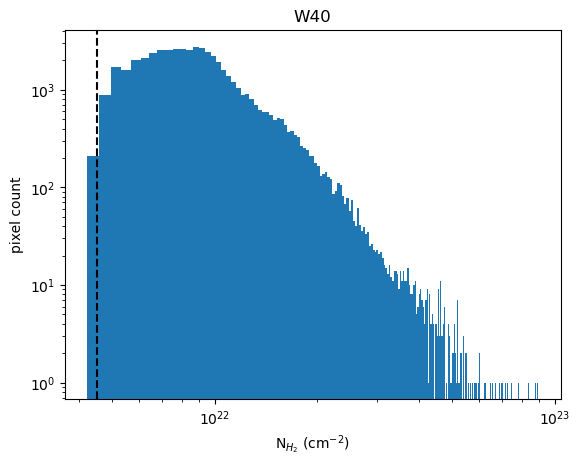

2.548458710348008
2276.305253222503
2.548458710348008
The escape velocity is: 2.7715688725567595
The escape velocity considering the full map size is: 2.7715688725567595


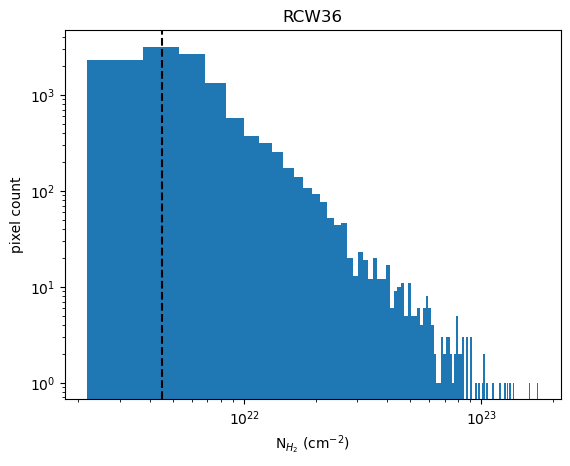

2.7388469177664976
1744.5277954169717
2.7388469177664976
The escape velocity is: 2.3404765430874397
The escape velocity considering the full map size is: 2.3404765430874397


FileNotFoundError: [Errno 2] No such file or directory: '../data_timescale/colDens/RCW120_coldens_high_reproj.fits'

In [8]:
## Calculate the mass, size and escape velocity in the FEEDBACK maps
for name in names.keys():
    ## get the name of the region
    reg_name = names[name][-1]
    
    ## open the fits file
    hdu = pyfits.open('../data_timescale/colDens/' + reg_name + '_coldens_high_reproj.fits')
    data = hdu[0].data
    header = hdu[0].header
    
    ## handle unrealisticly low column density values and zero
    data[data <= 2e21] = np.nan
    
    ## create the column density PDF
    data_rav = data.ravel()
    data_rav = data_rav[~np.isnan(data_rav)]
   

    #### plotting ####
    N_bg = plot_hist_getNbg(data_rav, reg_name)
    
    #####################
    
    ## calculate the pixel size in pc^2
    pix_size = header['CDELT2'] * np.pi * names[name][0] / 180.
    pix_area = pix_size**2 ## pc**2
    
    ## first estimate of the area and radius
    area1 = pix_area * np.nansum(data) / np.nanmean(data)
    radius1 = np.sqrt(area1 / np.pi)
    print(radius1)
    
    ## remove the background
    data_nobg = data - N_bg
    
    ## select molecular gas
    #data_nobg[data_nobg < 2.0e21] = np.nan
    
    ## calculate and print the total mass
    data_nobg = data_nobg * mol_mass ## kg /cm**2 
    tot_mass = np.nansum(data_nobg) * pix_area * pc_in_cm**2 / m_sun
    print(tot_mass)
    
    cloud_area = pix_area * np.nansum(data_nobg) / np.nanmean(data_nobg)
    print(np.sqrt(cloud_area/np.pi))
    
    vesc = v_escape(tot_mass, np.sqrt(cloud_area/np.pi))
    print("The escape velocity is: {vesc}".format(vesc = vesc))
    vesc1 = v_escape(tot_mass, radius1)
    print("The escape velocity considering the full map size is: {vesc}".format(vesc = vesc1))
    
    #print(tot_mass / names[name][-2] / 1.0e6)
    

In [ ]:
## CODE USED TO CREATE UNIFORM COLUMN DENSITY MAPS

'''
## reproject the column density maps
for name in names.keys():
    reg_name = names[name][-1]
    try:
        hdu = pyfits.open('../data_timescale/colDens/' + reg_name + '_coldens_high.fits')
        #hdu.info()
    except:
        print("Could not open the column density file for:" + reg_name)
    
    hdu2 = pyfits.open('../data_timescale/integrated/' + name + '_integrated.fits')
    #hdu2.info()
    header2 = hdu2[0].header
    
    ## reproject
    array, footprint = reproject_interp(hdu, header2)
    newHDU = pyfits.PrimaryHDU(array, header2)
    newHDU.writeto('../data_timescale/colDens/' + reg_name + '_coldens_high_reproj.fits',overwrite=True)
    
'''

'''
## reproject RCW 120 PPMAP from Higal
hdu = pyfits.open('../data_timescale/colDens/l347_cdens.fits')
hdu2 = pyfits.open('../data_timescale/integrated/RCW120_CII_final_20_8_0p5_clean_integrated.fits')
header2 = hdu2[0].header

array, footprint = reproject_interp(hdu, header2)
array = array * 1e20
newHDU = pyfits.PrimaryHDU(array, header2)
newHDU.writeto('../data_timescale/colDens/RCW120_coldens_high_reproj_PPMAP.fits',overwrite=True)
'''

'''
## reproject RCW 36 based on the CO map (which covers the full region)
hdu = pyfits.open('../data_timescale/colDens/RCW36_coldens_high.fits')
hdu2 = pyfits.open('../data_timescale/CO_data/RCW36_integratedIntensity12CO.fits')
header2 = hdu2[0].header

array, footprint = reproject_interp(hdu, header2)
newHDU = pyfits.PrimaryHDU(array, header2)
newHDU.writeto('../data_timescale/colDens/RCW36_coldens_high_reproj.fits',overwrite=True)
'''

'''
## convert the Orion A map to Nh2 and reproject to the [CII] map
hdu = pyfits.open('../data_timescale/colDens/oriona_coldens_hires.fits')
hdu.info()
data = hdu[0].data[0][0]
data = data*1.105e21  ## conversion factor from Guver et al. (2009)

header = hdu[0].header ## update the header
del header['CTYPE3']
del header['CRVAL3']
del header['CDELT3']
del header['CRPIX3']
del header['CROTA3']
del header['CTYPE4']
del header['CRVAL4']
del header['CDELT4']
del header['CRPIX4']
del header['CROTA4']
#header['NAXIS'] = 2

newHDU = pyfits.PrimaryHDU(data, hdu[0].header)
newHDU.writeto('../data_timescale/colDens/M42_coldens_high.fits')

## reprojection of the Orion A map
hdu = pyfits.open('../data_timescale/colDens/M42_coldens_high.fits')
hdu.info()
hdu2 = pyfits.open('../data_timescale/integrated/OrionA_CII_final_20_8_0p5_clean_integrated.fits')
header2 = hdu2[0].header

array, footprint = reproject_interp(hdu, header2)
newHDU = pyfits.PrimaryHDU(array, header2)
newHDU.writeto('../data_timescale/colDens/M42_coldens_high_reproj.fits',overwrite=True)
'''